## Task Description

Projection: Solve the life-cycle consumption example using collocation.
Use 7th degree polynomials.


Integration: Assume a simple derivative is of the form
Φ(ST ) = S^2_T − 30ST , where S follows a geometric Wiener process with
volatility σ. Calculate its price F(t,s) by Gauss-Hermite quadrature on
each s ∈ [40, 60]. Use the following parameters:
r = .01, σ = .4,T − t = .5.
Plot F against s

## Projection

In [23]:
# Import necessary packages
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt

# Integration
from scipy.special import roots_hermite



In [2]:
# Parameters
rho = 0.05      # Time preference rate
r = 0.06        # Interest rate
T = 30          # Time horizon
a0 = 1          # Initial assets
aT_desired = 0  # Desired terminal assets


In [5]:
# Implementing the ODE System and Boundary Conditions
def odes(t, y):
    """
    Defines the system of ODEs for the Life-Cycle Consumption problem.
    
    Parameters:
    - t: Time variable
    - y: Array containing [a(t), lambda(t)]
    
    Returns:
    - dydt: Array of derivatives [da/dt, dlambda/dt]
    """
    a = y[0]
    lamb = y[1]
    
    # Optimality condition: c(t) = e^{(r - rho)t} / lambda(t)
    c_t = np.exp((r - rho)*t) / lamb
    
    # ODEs
    da_dt = r * a - c_t
    dlamb_dt = -r * lamb
    
    return np.array([da_dt, dlamb_dt])


# Boundary Conditions
def boundary_conditions(ya, yb):
    """
    Defines the boundary conditions for the BVP.
    
    Parameters:
    - ya: Solution array at the start (t=0)
    - yb: Solution array at the end (t=T)
    
    Returns:
    - bc: Array of residuals for the boundary conditions
    """
    # Boundary conditions:
    # a(0) = a0 = 1
    # a(T) = aT_desired = 0
    return np.array([ya[0] - a0, yb[0] - aT_desired])


In [6]:
# Initial mesh
t_initial = np.linspace(0, T, 100)

# Initial guess for y = [a(t), lambda(t)]
# Linear guess for a(t): starts at a0 and decreases to aT_desired
a_guess = a0 * (1 - t_initial / T)

# Exponential guess for lambda(t): from lambda0 at t=0 decreasing exponentially
lambda0_guess = (1 - np.exp(-rho * T)) / rho  # Analytical value for lambda0
lambda_guess = lambda0_guess * np.exp(-r * t_initial)

# Combine into a single array
y_initial = np.vstack((a_guess, lambda_guess))


In [7]:
# Solve the BVP
solution = solve_bvp(odes, boundary_conditions, t_initial, y_initial, verbose=2, max_nodes=1000)


   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.16e-02       0.00e+00          100            99       
       2          6.31e-06       0.00e+00          199             0       
Solved in 2 iterations, number of nodes 199. 
Maximum relative residual: 6.31e-06 
Maximum boundary residual: 0.00e+00


In [20]:
if solution.status != 0:
    print("WARNING: The solver did not converge!")
else:
    print("The solver converged successfully.")

# Extract the mesh and solution
t_solution = solution.x
a_solution = solution.y[0]
lambda_solution = solution.y[1]

# Compute consumption c(t)
c_solution = np.exp((r - rho)*t_solution) / lambda_solution


# Analytical solution for comparison
def analytical_consumption(t, rho, r, lambda0):
    return (rho * np.exp((r - rho)*t)) / (1 - np.exp(-rho*T))

# Compute analytical consumption
c_analytical = analytical_consumption(t_solution, rho, r, lambda0_guess)


The solver converged successfully.


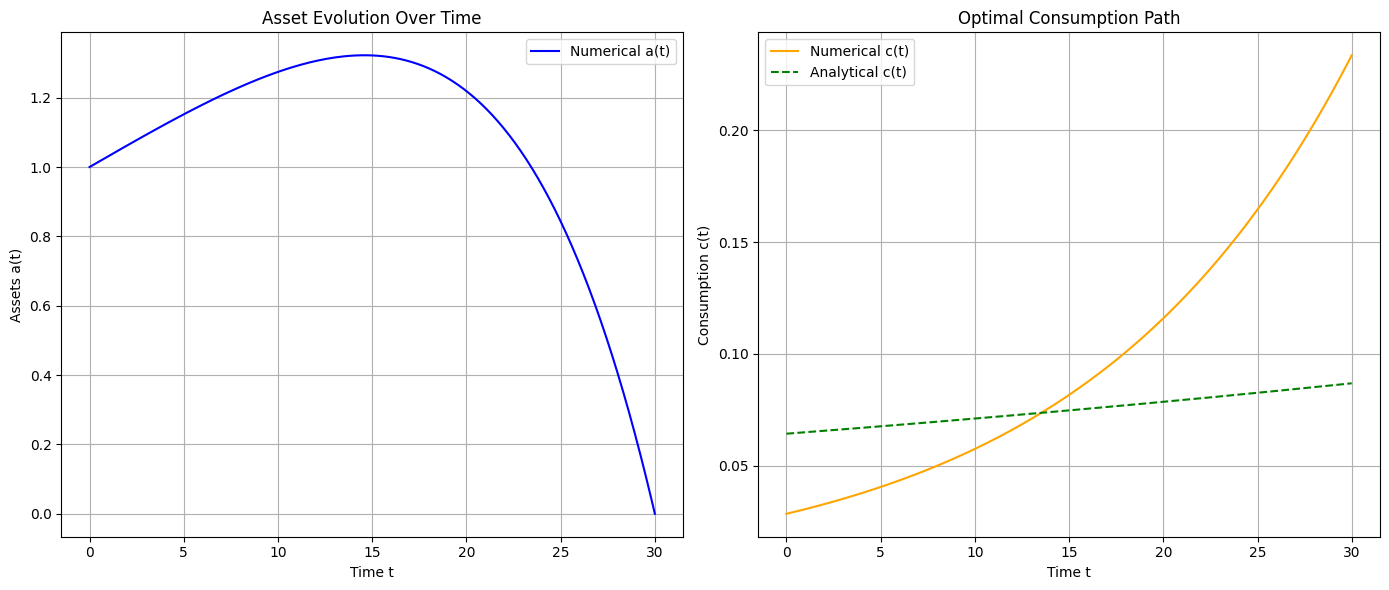

In [22]:
# Plotting

plt.figure(figsize=(14, 6))

# Plot Asset Evolution a(t)
plt.subplot(1, 2, 1)
plt.plot(t_solution, a_solution, label='Numerical a(t)', color='blue')
plt.title('Asset Evolution Over Time')
plt.xlabel('Time t')
plt.ylabel('Assets a(t)')
plt.grid(True)
plt.legend()

# Plot Consumption c(t)
plt.subplot(1, 2, 2)
plt.plot(t_solution, c_solution, label='Numerical c(t)', color='orange')
plt.plot(t_solution, c_analytical, '--', label='Analytical c(t)', color='green')
plt.title('Optimal Consumption Path')
plt.xlabel('Time t')
plt.ylabel('Consumption c(t)')
plt.grid(True)
plt.legend()

plt.tight_layout()  
plt.show()


## Integration

In [27]:
# Defining parameters
r = 0.01
sigma = 0.4
T_t = 0.5   # Time to maturity/ delta t

# Range of s
s_values = np.linspace(40, 60, 100) # 100 points between 40 and 60

# Number of quadrature points
n = 20

# Get the Gauss-Hermite nodes and weights
nodes, weights = roots_hermite(n)

"""After Defining S^2_T and doing variables substituting we will end up with:
            - ST = s*exp(r-(sigma^2)/2)Delta_t + sigma*sqrt(Delta_t)*Z 
            - After substitution: Z = sqrt(2)*x
            --> ST = s * exp(A + B*x), where 
            """

# Constants
A = (r - 0.5*sigma**2)*T_t
B = sigma * np.sqrt(2*T_t)

In [28]:
# Precompute constant multiplier
discount_factor = np.exp(-r * T_t) / np.sqrt(np.pi)

# Initialize an array to store F(t, s)
F_values = np.zeros_like(s_values)

# Iterate over each s
for idx, s in enumerate(s_values):
    # Compute the terms inside the expectation
    term1 = s**2 * np.exp(2 * A + 2 * B * nodes)
    term2 = 30 * s * np.exp(A + B * nodes)

    # Compute the weighted sum 
    expectation = np.sum(weights * (term1 - term2))

    # Multiply by the discount factor
    F = discount_factor * expectation

    # Store the result in the list
    F_values[idx] = F

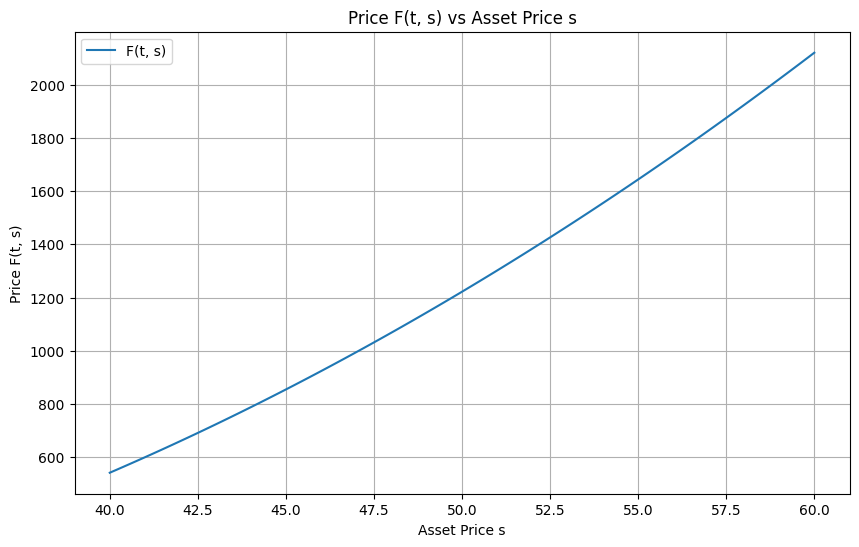

In [29]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(s_values, F_values, label='F(t, s)')
plt.title('Price F(t, s) vs Asset Price s')
plt.xlabel('Asset Price s')
plt.ylabel('Price F(t, s)')
plt.grid(True)
plt.legend()
plt.show()
